<a href="https://colab.research.google.com/github/Nikitakhairnar/BE-Project-GB15/blob/main/Translation_Hindi_to_English_adam_optimizer_TTS_using_tacotron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
import os

In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import tensorflow
import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense,TimeDistributed,Embedding,Bidirectional
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from string import digits
import nltk
import re
import string
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', -1)

<ipython-input-5-41c9e93ae06c>:16: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U -q PyDrive
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
 
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/file/d/17ENQNGImPbaYq0ScRhBXbIjMiByz3QJ5/view?usp=share_link'
 
import pandas as pd
 
# to get the id part of the file
id = link.split("/")[-2]
 
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('hindi_eng_parallel.csv') 
 
lines = pd.read_csv('hindi_eng_parallel.csv')

In [ ]:
lines = lines[:30000]
lines.head()

,hindi,english
0,अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें,Give your application an accessibility workout
1,एक्सेर्साइसर पहुंचनीयता अन्वेषक,Accerciser Accessibility Explorer
2,निचले पटल के लिए डिफोल्ट प्लग-इन खाका,The default plugin layout for the bottom panel
3,ऊपरी पटल के लिए डिफोल्ट प्लग-इन खाका,The default plugin layout for the top panel
4,उन प्लग-इनों की सूची जिन्हें डिफोल्ट रूप से निष्क्रिय किया गया है,A list of plugins that are disabled by default


In [ ]:
lines.shape

(30000, 2)

In [ ]:
# Lowercase all characters
lines['english']=lines['english'].apply(lambda x: str(x))
lines['hindi']=lines['hindi'].apply(lambda x: str(x))
lines['english']=lines['english'].apply(lambda x: x.lower())
lines['hindi']=lines['hindi'].apply(lambda x: x.lower())

In [ ]:
# Import stopwords with nltk.
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#remove stop words 
lines['english']=lines['english'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
lines['hindi']=lines['hindi'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [ ]:
# Remove quotes, replace quotes 
lines['english']=lines['english'].apply(lambda x: re.sub("'", '', x))
lines['hindi']=lines['hindi'].apply(lambda x: re.sub("'", '', x))

In [ ]:
lines.head()

,hindi,english
0,अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें,give application accessibility workout
1,एक्सेर्साइसर पहुंचनीयता अन्वेषक,accerciser accessibility explorer
2,निचले पटल के लिए डिफोल्ट प्लग-इन खाका,default plugin layout bottom panel
3,ऊपरी पटल के लिए डिफोल्ट प्लग-इन खाका,default plugin layout top panel
4,उन प्लग-इनों की सूची जिन्हें डिफोल्ट रूप से निष्क्रिय किया गया है,list plugins disabled default


In [ ]:
exclude = set(string.punctuation) # Set of all special characters
# Remove all the special characters
lines['english']=lines['english'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines['hindi']=lines['hindi'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [ ]:
lines.head()

,hindi,english
0,अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें,give application accessibility workout
1,एक्सेर्साइसर पहुंचनीयता अन्वेषक,accerciser accessibility explorer
2,निचले पटल के लिए डिफोल्ट प्लगइन खाका,default plugin layout bottom panel
3,ऊपरी पटल के लिए डिफोल्ट प्लगइन खाका,default plugin layout top panel
4,उन प्लगइनों की सूची जिन्हें डिफोल्ट रूप से निष्क्रिय किया गया है,list plugins disabled default


In [ ]:
lines.tail()

,hindi,english
29995,आयात करें m,mport
29996,आयात करें m,mport
29997,क्या आप s से सत्र आयात करना चाहते हैं,want import session s
29998,उस तरह से पिछले सत्र से पुरानी फाइलें लिखने के बाद प्रयोग लायक होगी,way old files previous sessions usable burning
29999,सत्र आयात करें m,mport session


In [ ]:
#create a translation table to be used for replacing digits in a string
remove_digits = str.maketrans('', '', digits)

In [ ]:
remove_digits

{48: None,
 49: None,
 50: None,
 51: None,
 52: None,
 53: None,
 54: None,
 55: None,
 56: None,
 57: None}

In [ ]:
a = lines['english'][0].translate(remove_digits)

In [ ]:
a

'give application accessibility workout'

In [ ]:
a.strip()

'give application accessibility workout'

In [ ]:
# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)
lines['english']=lines['english'].apply(lambda x: x.translate(remove_digits))
lines['hindi']=lines['hindi'].apply(lambda x: x.translate(remove_digits))

lines['hindi'] = lines['hindi'].apply(lambda x: re.sub("[२३०८१५७९४६]", "", x))

In [ ]:
# Remove extra spaces
lines['english']=lines['english'].apply(lambda x: x.strip())
lines['hindi']=lines['hindi'].apply(lambda x: x.strip())

#replace " +" with " " using re.sub() method
lines['english']=lines['english'].apply(lambda x: re.sub(" +", " ", x))
lines['hindi']=lines['hindi'].apply(lambda x: re.sub(" +", " ", x))

In [ ]:
# Add start and end tokens to target sequences which are english sentences
lines['english'] = lines['english'].apply(lambda x : 'START_ '+ x + ' _END')

In [ ]:
lines['english'][0]

'START_ give application accessibility workout _END'

In [ ]:
### Get English Vocabulary and add missing words from dataset
all_eng_words=set()
for eng in lines['english']:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)

In [ ]:
all_eng_words

{'stash',
 'go',
 'detected',
 'gives',
 'csharp',
 'folder…',
 'choose',
 'optimized',
 'role',
 'enterings',
 'removed',
 'dual',
 'executing',
 'os',
 'monochrome',
 'reached',
 'ejected',
 'partitions',
 'warned',
 'directories',
 'clos',
 'fully',
 'holding',
 'play',
 'update',
 'footer',
 'atoms',
 'mention',
 'them',
 'stepping',
 'wizard',
 'gnome',
 'impossible',
 'completed',
 'locally',
 'reshuffle',
 'nces',
 'swiss',
 'parameter',
 'installed',
 'font',
 'internationalization',
 'identity',
 'threes',
 'across',
 'install',
 'development',
 'still',
 'draftbox',
 'entire',
 'grep',
 'scheme',
 'flag',
 'autocomplete',
 'blondes',
 'vcd',
 'details',
 'allocate',
 'error',
 'running',
 'run',
 'owner',
 'normal',
 'keyword',
 'forwarded',
 'feature',
 'val',
 'bear',
 'initializer',
 'recursive',
 'isabel',
 'plait',
 'previous',
 'related',
 'p',
 'italic',
 'temporary',
 'inline',
 'sender',
 'view…',
 'round',
 'effect',
 'south',
 'provided',
 'brazilian',
 'buffer',
 

In [ ]:
### Get Hindi Vocabulary and add missing words from dataset
all_hindi_words=set()
for hin in lines['hindi']:
    for word in hin.split():
        if word not in all_hindi_words:
            all_hindi_words.add(word)

In [ ]:
all_hindi_words

{'पाप',
 'मिलाया',
 'लगाने',
 'एडीटर',
 'सारे',
 'पहुंचने',
 'गैर',
 'enterings',
 'चोटी',
 'os',
 'इधर',
 'सम्बन्धित',
 'रेपोसिटरीः',
 'ही',
 'बदलें',
 'निकास',
 'rajeshkajha',
 'फीफो',
 'हैं',
 'आकार',
 'मॉड्यूल्सः',
 'मौड्यूल',
 'अन्यों',
 'update',
 'कैसे',
 'इनबाक्स',
 'redhat',
 'पोकर',
 'विडजेट',
 'gnome',
 'completed',
 'लिपि',
 'भिन्न',
 'सोलिटेयर',
 'विडगेट',
 'चलाएँः',
 'ठीक',
 'है…',
 'टेक्स्ट',
 'स्टेटसबार',
 'चिपकाओ',
 'विस्तारित',
 'निकलने',
 'दिखाओ',
 'वाक्य',
 'सापेक्ष',
 'होगी',
 'development',
 'रैपर',
 'ब्रैसेरोसीडी',
 'हार्ड',
 'जीता',
 'स्केलिंग',
 'grep',
 'प्रारूपः',
 'विवरणः',
 'संगीता',
 'पूरा',
 'लें',
 'क्रम',
 'details',
 'allocate',
 'error',
 'क्लोज',
 'जोड़ेंः',
 'big',
 'चेकः',
 'बाज',
 'सीमांत',
 'स्ट्रिंग',
 'उपकरणपट्टी',
 'एटम',
 'हमेशा',
 'बदलाव',
 'हुये',
 'फ़ोल्डरः',
 'देते',
 'escape',
 'दिखायें',
 'सहेजेंः',
 'प्रारंभ',
 'उन्नत',
 'हीरा',
 'बीएसडी',
 'दोनों',
 'p',
 'चाहते',
 'बचाएँ',
 'एक्सेरसाइसर',
 'बांया',
 'टूडू',
 'अस्थाई',
 'रिवर',
 'विका

In [ ]:
#claculate length of text of each row
lines['length_eng']=lines['english'].apply(lambda x:len(x.split(" ")))
lines['length_hin']=lines['hindi'].apply(lambda x:len(x.split(" ")))

In [ ]:
lines['length_eng']

0        6
1        5
2        7
3        7
4        6
        ..
29995    3
29996    3
29997    6
29998    9
29999    4
Name: length_eng, Length: 30000, dtype: int64

In [ ]:
lines.head()

,hindi,english,length_eng,length_hin
0,अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें,START_ give application accessibility workout _END,6,8
1,एक्सेर्साइसर पहुंचनीयता अन्वेषक,START_ accerciser accessibility explorer _END,5,3
2,निचले पटल के लिए डिफोल्ट प्लगइन खाका,START_ default plugin layout bottom panel _END,7,7
3,ऊपरी पटल के लिए डिफोल्ट प्लगइन खाका,START_ default plugin layout top panel _END,7,7
4,उन प्लगइनों की सूची जिन्हें डिफोल्ट रूप से निष्क्रिय किया गया है,START_ list plugins disabled default _END,6,12


In [ ]:
#English text with length >30
lines[lines['length_eng']>30].shape

(10, 4)

In [ ]:
#Hindi text with length>30
lines[lines['length_hin']>30].shape

(63, 4)

In [ ]:
#get text whose length<=20
lines=lines[lines['length_eng']<=20]
lines=lines[lines['length_hin']<=20]

In [ ]:
print("maximum length of Hindi Sentence ",max(lines['length_hin']))
print("maximum length of English Sentence ",max(lines['length_eng']))

maximum length of Hindi Sentence  20
maximum length of English Sentence  20


In [ ]:
max_length_src=max(lines['length_hin'])
max_length_tar=max(lines['length_eng'])

In [ ]:
print(max_length_src)

20


In [ ]:
print(max_length_tar)

20


In [ ]:
input_words = sorted(list(all_hindi_words))
target_words = sorted(list(all_eng_words))

num_encoder_tokens = len(all_hindi_words)
num_decoder_tokens = len(all_eng_words)
num_encoder_tokens, num_decoder_tokens

(3405, 2622)

In [ ]:
input_words

['a',
 'acard',
 'actiongroupeditorinsert',
 'actions',
 'add',
 'addrcheck',
 'advanced',
 'after',
 'aisleriot',
 'all',
 'allocate',
 'along',
 'analyzer',
 'and',
 'andor',
 'anjut',
 'anjuta',
 'another',
 'api',
 'app',
 'applicable',
 'applicablenot',
 'args',
 'assistance',
 'assoc',
 'assword',
 'at',
 'atkब्रिजः',
 'author',
 'autoformat',
 'autogen',
 'automake',
 'b',
 'balasubramaniam',
 'balsa',
 'baobab',
 'bar',
 'bd',
 'berkeley',
 'beside',
 'best',
 'bgt',
 'big',
 'bind',
 'bluray',
 'blurb',
 'bo',
 'boston',
 'bottom',
 'brasero',
 'bsd',
 'burn',
 'button',
 'c',
 'cachegrind',
 'card',
 'cc',
 'cccanalyzer',
 'cd',
 'cddvd',
 'cdr',
 'cdrdao',
 'cdrecord',
 'cdrom',
 'cdrw',
 'cdtext',
 'changelog',
 'cherry',
 'chooser',
 'clang',
 'class',
 'classt',
 'cleanup',
 'codec',
 'column',
 'com',
 'commit',
 'commits',
 'compiled',
 'completed',
 'copy',
 'copyright',
 'cpu',
 'creator',
 'ctrlc',
 'ctrlx',
 'ctrlz',
 'cvs',
 'cvsroot',
 'd',
 'dao',
 'date',
 'days

In [ ]:
target_words

['START_',
 '_END',
 'a',
 'able',
 'abort',
 'aborted',
 'above',
 'absolute',
 'ac',
 'accelerator',
 'accelerator…',
 'accentuated',
 'accept',
 'acceptable',
 'accepted',
 'accerciser',
 'access',
 'accessed',
 'accessibility',
 'accessible',
 'accessibles',
 'according',
 'accordion',
 'ace',
 'aces',
 'across',
 'act',
 'acti',
 'action',
 'actionable',
 'actions',
 'activatable',
 'activate',
 'activated',
 'active',
 'actual',
 'adaptive',
 'add',
 'added',
 'addition',
 'additional',
 'addrcheck',
 'address',
 'addressbook',
 'addresses',
 'adds',
 'add…',
 'advance',
 'advanced',
 'advised',
 'affects',
 'again',
 'agnes',
 'aim',
 'aisleriot',
 'al',
 'albert',
 'alert',
 'algorithm',
 'alidate',
 'all',
 'alleys',
 'allocate',
 'allocated',
 'allow',
 'allows',
 'alone',
 'along',
 'alpha',
 'alphabetical',
 'alphanumeric',
 'alphanumerics',
 'already',
 'also',
 'alt',
 'alternating',
 'alternative',
 'always',
 'american',
 'among',
 'analyser',
 'analysing',
 'analyze',


In [ ]:
num_decoder_tokens

2622

In [ ]:
num_decoder_tokens+=1

In [ ]:
num_decoder_tokens

2623

In [ ]:
num_encoder_tokens

3405

In [ ]:
#create dictionary representation for input_words and target_words
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

In [ ]:
input_token_index

{'a': 1,
 'acard': 2,
 'actiongroupeditorinsert': 3,
 'actions': 4,
 'add': 5,
 'addrcheck': 6,
 'advanced': 7,
 'after': 8,
 'aisleriot': 9,
 'all': 10,
 'allocate': 11,
 'along': 12,
 'analyzer': 13,
 'and': 14,
 'andor': 15,
 'anjut': 16,
 'anjuta': 17,
 'another': 18,
 'api': 19,
 'app': 20,
 'applicable': 21,
 'applicablenot': 22,
 'args': 23,
 'assistance': 24,
 'assoc': 25,
 'assword': 26,
 'at': 27,
 'atkब्रिजः': 28,
 'author': 29,
 'autoformat': 30,
 'autogen': 31,
 'automake': 32,
 'b': 33,
 'balasubramaniam': 34,
 'balsa': 35,
 'baobab': 36,
 'bar': 37,
 'bd': 38,
 'berkeley': 39,
 'beside': 40,
 'best': 41,
 'bgt': 42,
 'big': 43,
 'bind': 44,
 'bluray': 45,
 'blurb': 46,
 'bo': 47,
 'boston': 48,
 'bottom': 49,
 'brasero': 50,
 'bsd': 51,
 'burn': 52,
 'button': 53,
 'c': 54,
 'cachegrind': 55,
 'card': 56,
 'cc': 57,
 'cccanalyzer': 58,
 'cd': 59,
 'cddvd': 60,
 'cdr': 61,
 'cdrdao': 62,
 'cdrecord': 63,
 'cdrom': 64,
 'cdrw': 65,
 'cdtext': 66,
 'changelog': 67,
 'cherry

In [ ]:
target_token_index

{'START_': 1,
 '_END': 2,
 'a': 3,
 'able': 4,
 'abort': 5,
 'aborted': 6,
 'above': 7,
 'absolute': 8,
 'ac': 9,
 'accelerator': 10,
 'accelerator…': 11,
 'accentuated': 12,
 'accept': 13,
 'acceptable': 14,
 'accepted': 15,
 'accerciser': 16,
 'access': 17,
 'accessed': 18,
 'accessibility': 19,
 'accessible': 20,
 'accessibles': 21,
 'according': 22,
 'accordion': 23,
 'ace': 24,
 'aces': 25,
 'across': 26,
 'act': 27,
 'acti': 28,
 'action': 29,
 'actionable': 30,
 'actions': 31,
 'activatable': 32,
 'activate': 33,
 'activated': 34,
 'active': 35,
 'actual': 36,
 'adaptive': 37,
 'add': 38,
 'added': 39,
 'addition': 40,
 'additional': 41,
 'addrcheck': 42,
 'address': 43,
 'addressbook': 44,
 'addresses': 45,
 'adds': 46,
 'add…': 47,
 'advance': 48,
 'advanced': 49,
 'advised': 50,
 'affects': 51,
 'again': 52,
 'agnes': 53,
 'aim': 54,
 'aisleriot': 55,
 'al': 56,
 'albert': 57,
 'alert': 58,
 'algorithm': 59,
 'alidate': 60,
 'all': 61,
 'alleys': 62,
 'allocate': 63,
 'alloca

In [ ]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [ ]:
reverse_input_char_index

{1: 'a',
 2: 'acard',
 3: 'actiongroupeditorinsert',
 4: 'actions',
 5: 'add',
 6: 'addrcheck',
 7: 'advanced',
 8: 'after',
 9: 'aisleriot',
 10: 'all',
 11: 'allocate',
 12: 'along',
 13: 'analyzer',
 14: 'and',
 15: 'andor',
 16: 'anjut',
 17: 'anjuta',
 18: 'another',
 19: 'api',
 20: 'app',
 21: 'applicable',
 22: 'applicablenot',
 23: 'args',
 24: 'assistance',
 25: 'assoc',
 26: 'assword',
 27: 'at',
 28: 'atkब्रिजः',
 29: 'author',
 30: 'autoformat',
 31: 'autogen',
 32: 'automake',
 33: 'b',
 34: 'balasubramaniam',
 35: 'balsa',
 36: 'baobab',
 37: 'bar',
 38: 'bd',
 39: 'berkeley',
 40: 'beside',
 41: 'best',
 42: 'bgt',
 43: 'big',
 44: 'bind',
 45: 'bluray',
 46: 'blurb',
 47: 'bo',
 48: 'boston',
 49: 'bottom',
 50: 'brasero',
 51: 'bsd',
 52: 'burn',
 53: 'button',
 54: 'c',
 55: 'cachegrind',
 56: 'card',
 57: 'cc',
 58: 'cccanalyzer',
 59: 'cd',
 60: 'cddvd',
 61: 'cdr',
 62: 'cdrdao',
 63: 'cdrecord',
 64: 'cdrom',
 65: 'cdrw',
 66: 'cdtext',
 67: 'changelog',
 68: 'ch

In [ ]:
reverse_target_char_index

{1: 'START_',
 2: '_END',
 3: 'a',
 4: 'able',
 5: 'abort',
 6: 'aborted',
 7: 'above',
 8: 'absolute',
 9: 'ac',
 10: 'accelerator',
 11: 'accelerator…',
 12: 'accentuated',
 13: 'accept',
 14: 'acceptable',
 15: 'accepted',
 16: 'accerciser',
 17: 'access',
 18: 'accessed',
 19: 'accessibility',
 20: 'accessible',
 21: 'accessibles',
 22: 'according',
 23: 'accordion',
 24: 'ace',
 25: 'aces',
 26: 'across',
 27: 'act',
 28: 'acti',
 29: 'action',
 30: 'actionable',
 31: 'actions',
 32: 'activatable',
 33: 'activate',
 34: 'activated',
 35: 'active',
 36: 'actual',
 37: 'adaptive',
 38: 'add',
 39: 'added',
 40: 'addition',
 41: 'additional',
 42: 'addrcheck',
 43: 'address',
 44: 'addressbook',
 45: 'addresses',
 46: 'adds',
 47: 'add…',
 48: 'advance',
 49: 'advanced',
 50: 'advised',
 51: 'affects',
 52: 'again',
 53: 'agnes',
 54: 'aim',
 55: 'aisleriot',
 56: 'al',
 57: 'albert',
 58: 'alert',
 59: 'algorithm',
 60: 'alidate',
 61: 'all',
 62: 'alleys',
 63: 'allocate',
 64: 'al

In [ ]:
lines.head(15)

,hindi,english,length_eng,length_hin
0,अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें,START_ give application accessibility workout _END,6,8
1,एक्सेर्साइसर पहुंचनीयता अन्वेषक,START_ accerciser accessibility explorer _END,5,3
2,निचले पटल के लिए डिफोल्ट प्लगइन खाका,START_ default plugin layout bottom panel _END,7,7
3,ऊपरी पटल के लिए डिफोल्ट प्लगइन खाका,START_ default plugin layout top panel _END,7,7
4,उन प्लगइनों की सूची जिन्हें डिफोल्ट रूप से निष्क्रिय किया गया है,START_ list plugins disabled default _END,6,12
5,अवधि को हाइलाइट रकें,START_ highlight duration _END,4,4
6,पहुंचनीय आसंधि नोड को चुनते समय हाइलाइट बक्से की अवधि,START_ duration highlight box selecting accessible nodes _END,8,10
7,सीमांत बोर्डर के रंग को हाइलाइट करें,START_ highlight border color _END,5,7
8,हाइलाइट किए गए सीमांत का रंग और अपारदर्शिता।,START_ color opacity highlight border _END,6,8
9,भराई के रंग को हाइलाइट करें,START_ highlight fill color _END,5,6


In [ ]:
#split dataset into train and test set
from sklearn.model_selection import train_test_split
X, y = lines['hindi'], lines['english']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=42)
X_train.shape, X_test.shape

((23819,), (5955,))

In [ ]:
X_train

22035    उभारें                                       
12022    प्रयोग कर रहा है जावा कम्पाइलर               
27442    टर्मिनल                                      
21047    फ्रेम                                        
11841    को मिटाएँ अनुसरण कर रहा है पैकेज से नहीं नहीं
                             ...                      
21733    नहीं समूह चयनित                              
5428     number                                       
864      प्रवेश सहायक                                 
15929    जोड़ें लाइब्रेरी                             
23821    anjuta प्लगइन                                
Name: hindi, Length: 23819, dtype: object

In [ ]:
y_train

22035    START_ highlight matching brackets _END                                       
12022    START_ generic natively compiled java project using gnu java compiler gcj _END
27442    START_ terminal _END                                                          
21047    START_ stack frame operations _END                                            
11841    START_ sure want remove following package project _END                        
                                  ...                                                  
21733    START_ group selected _END                                                    
5428     START_  _END                                                                  
864      START_ lo gin helper _END                                                     
15929    START_ add library _END                                                       
23821    START_ anjuta plugin project uses libanjuta framework _END                    
Name: english, Length: 23819, dt

In [ ]:
#create an array of specified size and data type
encoder_input_data = np.zeros((2, max_length_src),dtype='float32')
decoder_input_data = np.zeros((2, max_length_tar),dtype='float32')
decoder_target_data = np.zeros((2, max_length_tar, num_decoder_tokens),dtype='float32')

In [ ]:
def generate_batch(X = X_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

In [ ]:
latent_dim = 300
# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens+1, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [ ]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens+1, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.summary()
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 64
epochs = 10

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 300)    1021800     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 300)    787200      ['input_2[0][0]']                
                                                                                              

In [ ]:
model.save('hindi-to-eng-23-4-23.h5')

In [ ]:
a, b = next(generate_batch())

In [ ]:
a

[array([[ 796.,    0.,    0., ...,    0.,    0.,    0.],
        [2080.,  930., 2590., ...,    0.,    0.,    0.],
        [1449.,    0.,    0., ...,    0.,    0.,    0.],
        ...,
        [1073.,    0.,    0., ...,    0.,    0.,    0.],
        [2049., 2498., 2417., ...,    0.,    0.,    0.],
        [2742., 3048.,    0., ...,    0.,    0.,    0.]], dtype=float32),
 array([[1.000e+00, 1.009e+03, 1.343e+03, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [1.000e+00, 9.170e+02, 1.447e+03, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [1.000e+00, 2.306e+03, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        ...,
        [1.000e+00, 3.100e+01, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [1.000e+00, 2.029e+03, 1.729e+03, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [1.000e+00, 1.620e+02, 5.230e+02, ..., 0.000e+00, 0.000e+00,
         0.000e+00]], dtype=float32)]

In [ ]:
b

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [ ]:
X_train[2]

'निचले पटल के लिए डिफोल्ट प्लगइन खाका'

In [ ]:
model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples/batch_size,
                    epochs=10,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples/batch_size)

Epoch 1/10


<ipython-input-77-029ac434b37f>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),


372/372 [==============================] - 298s 765ms/step - loss: 4.9687 - accuracy: 0.2880 - val_loss: 4.2731 - val_accuracy: 0.3135
Epoch 2/10
372/372 [==============================] - 276s 742ms/step - loss: 3.6053 - accuracy: 0.3862 - val_loss: 2.9268 - val_accuracy: 0.4833
Epoch 3/10
372/372 [==============================] - 250s 673ms/step - loss: 2.2067 - accuracy: 0.5932 - val_loss: 1.7909 - val_accuracy: 0.6870
Epoch 4/10
372/372 [==============================] - 255s 687ms/step - loss: 1.2485 - accuracy: 0.7744 - val_loss: 1.1767 - val_accuracy: 0.8148
Epoch 5/10
372/372 [==============================] - 274s 737ms/step - loss: 0.7640 - accuracy: 0.8663 - val_loss: 0.9015 - val_accuracy: 0.8651
Epoch 6/10
372/372 [==============================] - 278s 748ms/step - loss: 0.5324 - accuracy: 0.9005 - val_loss: 0.7770 - val_accuracy: 0.8832
Epoch 7/10
372/372 [==============================] - 275s 738ms/step - loss: 0.4061 - accuracy: 0.9174 - val_loss: 0.7162 - val_accura

In [ ]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1

In [ ]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [ ]:
references = []

In [ ]:
candidates = []

In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input Hindi sentence:', X_train[k:k+1].values[0])
print('Actual English Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted English Translation:', decoded_sentence[:-4])
references.append([y_train[k:k+1].values[0][6:-4], decoded_sentence[:-4]])
candidates.append(decoded_sentence.split())

1/1 [==============================] - 0s 136ms/step
Input Hindi sentence: कार्ड चालों में एनीमेशन उपयोग करें या नहीं
Actual English Translation:  whether animate card moves 
Predicted English Translation:  whether animate card moves 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input Hindi sentence:', X_train[k:k+1].values[0])
print('Actual English Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted English Translation:', decoded_sentence[:-4])
references.append([y_train[k:k+1].values[0][6:-4], decoded_sentence[:-4]])
candidates.append(decoded_sentence.split())

1/1 [==============================] - 0s 227ms/step
Input Hindi sentence: प्रोग्राम पैरामीटर
Actual English Translation:  program parameters 
Predicted English Translation:  program parameters 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input Hindi sentence:', X_train[k:k+1].values[0])
print('Actual English Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted English Translation:', decoded_sentence[:-4])
references.append([y_train[k:k+1].values[0][6:-4], decoded_sentence[:-4]])
candidates.append(decoded_sentence.split())

1/1 [==============================] - 0s 31ms/step
Input Hindi sentence: पाठ को प्रयोक्ता को एंटर प्रविष्टि
Actual English Translation:  text show user enter entry 
Predicted English Translation:  text show user enter entry 


In [ ]:
from nltk.translate.bleu_score import sentence_bleu
# ref = [
#     'this is moonlight'.split(),
#     'Look, this is moonlight'.split(),
#     'moonlight it is'.split()
# ]
# test = 'this is moonlight'.split()
# print('BLEU score for test-> {}'.format(sentence_bleu(ref, test)))
 
# test01 = 'it is cat and moonlight'.split()
# print('BLEU score for test01-> {}'.format(sentence_bleu(ref, test01)))

print("BleU score", nltk.translate.bleu_score.corpus_bleu(references, candidates))

BleU score 0


In [ ]:
p=-1
test_gen = generate_batch(X_test, y_test, batch_size = 1)
test_references=[]
test_candidates=[]
for p in range(100):
  (input_seq, actual_output), _ = next(train_gen)
  decoded_sentence = decode_sequence(input_seq)
  # print('Input Hindi sentence:', X_test[p:p+1].values[0])
  # print('Actual English Translation:', y_test[p:p+1].values[0][6:-4])
  # print('Predicted English Translation:', decoded_sentence[:-4])
  test_references.append([y_train[k:k+1].values[0][6:-4], decoded_sentence[:-4]])
  test_candidates.append(decoded_sentence.split())

1/1 [==============================] - 0s 102ms/step


In [ ]:
print("BleU score", nltk.translate.bleu_score.corpus_bleu(test_references, test_candidates))

BleU score 1.7772032569279313e-233


/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

In [ ]:
import IPython
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
!pip3 install deep_phonemizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for deep_phonemizer: filename=deep_phonemizer-0.0.19-py3-none-any.whl size=33288 sha256=41f2a2d5fed346bccbee7121c2c9abea489cdca9be6a6c9a343476f3ae8127f9
  Stored in directory: /root/.cache/pip/wheels/26/81/93/0e3e82502719c66ecf9d445e063377034fc3d3149353fbefba
Successfully built deep_phonemizer


In [ ]:
# pip install torchaudio --ignore-installed torch
# import torchaudio
# !pip install markupsafe --user

In [ ]:
# !pip install torch==2.0.0
# !pip install torchaudio

In [ ]:
# !pip uninstall torchaudio -y
# !pip install torchaudio

Found existing installation: torchaudio 2.0.1
Uninstalling torchaudio-2.0.1:
  Successfully uninstalled torchaudio-2.0.1
  Using cached torchaudio-2.0.1-cp310-cp310-win_amd64.whl (2.1 MB)


In [ ]:
import torch
import torchaudio

matplotlib.rcParams["figure.figsize"] = [16.0, 4.8]

torch.random.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"

print(torch.__version__)
print(torchaudio.__version__)
print(device)

2.0.0+cu118
2.0.1+cu118
cpu


In [ ]:
symbols = "_-!'(),.:;? abcdefghijklmnopqrstuvwxyz"
look_up = {s: i for i, s in enumerate(symbols)}
print(look_up)
symbols = set(symbols)

{'_': 0, '-': 1, '!': 2, "'": 3, '(': 4, ')': 5, ',': 6, '.': 7, ':': 8, ';': 9, '?': 10, ' ': 11, 'a': 12, 'b': 13, 'c': 14, 'd': 15, 'e': 16, 'f': 17, 'g': 18, 'h': 19, 'i': 20, 'j': 21, 'k': 22, 'l': 23, 'm': 24, 'n': 25, 'o': 26, 'p': 27, 'q': 28, 'r': 29, 's': 30, 't': 31, 'u': 32, 'v': 33, 'w': 34, 'x': 35, 'y': 36, 'z': 37}


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input Hindi sentence:', X_train[k:k+1].values[0])
print('Actual English Translation:', y_train[k:k+1].values[0][6:-4])
predicted_trans = decoded_sentence[:-4]
print('Predicted English Translation:', decoded_sentence[:-4])

1/1 [==============================] - 0s 26ms/step
Input Hindi sentence: को मिटाएँ अनुसरण कर रहा है पैकेज से नहीं नहीं
Actual English Translation:  sure want remove following package project 
Predicted English Translation:  sure want remove following package project 


In [ ]:
predicted_trans

' sure want remove following package project '

In [ ]:
def text_to_sequence(text):
    text = text.lower()
    return [look_up[s] for s in text if s in symbols]


text = predicted_trans
print(text_to_sequence(text))

[11, 30, 32, 29, 16, 11, 34, 12, 25, 31, 11, 29, 16, 24, 26, 33, 16, 11, 17, 26, 23, 23, 26, 34, 20, 25, 18, 11, 27, 12, 14, 22, 12, 18, 16, 11, 27, 29, 26, 21, 16, 14, 31, 11]


In [ ]:
processor = torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH.get_text_processor()

text = predicted_trans
processed, lengths = processor(text)

print(processed)
print(lengths)

tensor([[11, 30, 32, 29, 16, 11, 34, 12, 25, 31, 11, 29, 16, 24, 26, 33, 16, 11,
         17, 26, 23, 23, 26, 34, 20, 25, 18, 11, 27, 12, 14, 22, 12, 18, 16, 11,
         27, 29, 26, 21, 16, 14, 31, 11]])
tensor([44], dtype=torch.int32)


In [ ]:
print([processor.tokens[i] for i in processed[0, : lengths[0]]])

[' ', 's', 'u', 'r', 'e', ' ', 'w', 'a', 'n', 't', ' ', 'r', 'e', 'm', 'o', 'v', 'e', ' ', 'f', 'o', 'l', 'l', 'o', 'w', 'i', 'n', 'g', ' ', 'p', 'a', 'c', 'k', 'a', 'g', 'e', ' ', 'p', 'r', 'o', 'j', 'e', 'c', 't', ' ']


In [ ]:
#Phoneme-based encoding
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()

text = predicted_trans
with torch.inference_mode():
    processed, lengths = processor(text)

print(processed)
print(lengths)

100%|██████████| 63.6M/63.6M [00:03<00:00, 21.5MB/s]


tensor([[11, 80, 83, 78, 11, 92, 12, 67, 81, 11, 78, 59, 66, 87, 91, 11, 52, 12,
         65, 69, 55, 68, 11, 77, 16, 64, 20, 63, 11, 77, 78, 12, 63, 40, 64, 81,
         11]])
tensor([37], dtype=torch.int32)


In [ ]:
print([processor.tokens[i] for i in processed[0, : lengths[0]]])

[' ', 'SH', 'UH', 'R', ' ', 'W', 'AA', 'N', 'T', ' ', 'R', 'IY', 'M', 'UW', 'V', ' ', 'F', 'AA', 'L', 'OW', 'IH', 'NG', ' ', 'P', 'AE', 'K', 'AH', 'JH', ' ', 'P', 'R', 'AA', 'JH', 'EH', 'K', 'T', ' ']


Downloading: "https://download.pytorch.org/torchaudio/models/tacotron2_english_phonemes_1500_epochs_wavernn_ljspeech.pth" to /root/.cache/torch/hub/checkpoints/tacotron2_english_phonemes_1500_epochs_wavernn_ljspeech.pth
100%|██████████| 107M/107M [00:00<00:00, 209MB/s] 


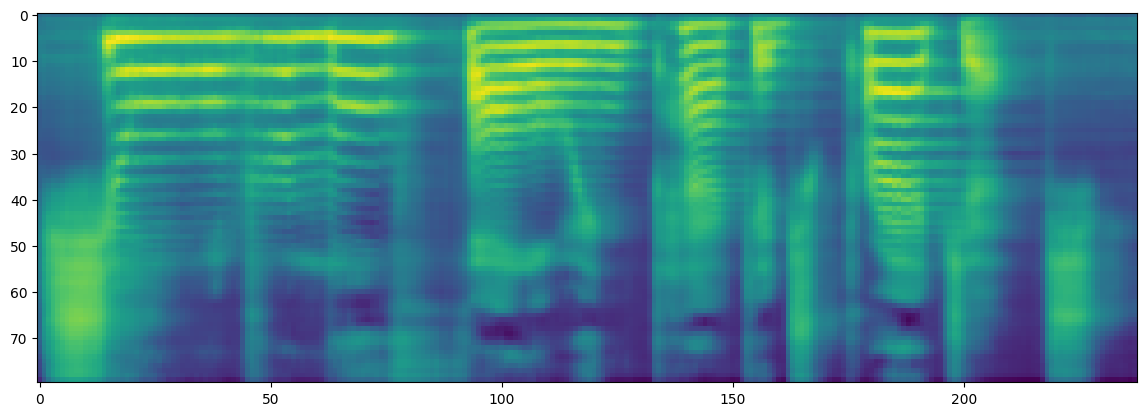

In [ ]:
#Spectrogram Generation
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH
processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)

text = predicted_trans

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, _, _ = tacotron2.infer(processed, lengths)


_ = plt.imshow(spec[0].cpu().detach())

torch.Size([80, 227])
torch.Size([80, 222])
torch.Size([80, 224])


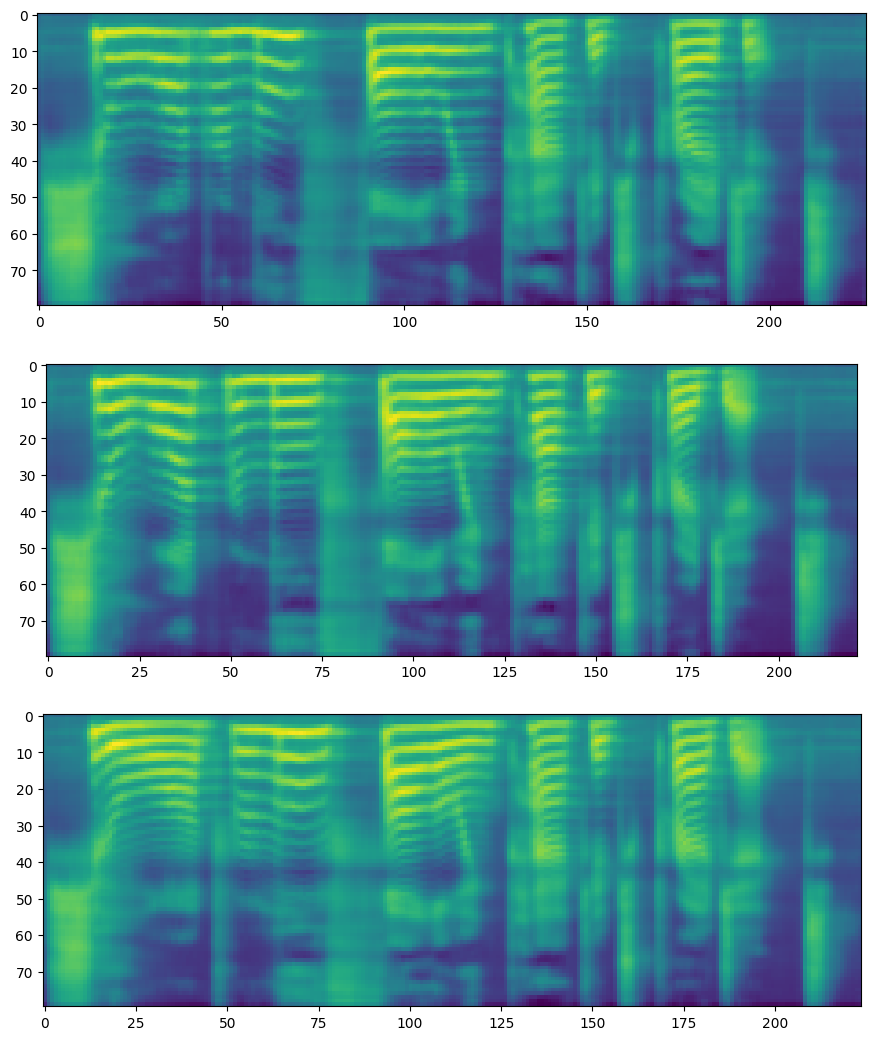

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(16, 4.3 * 3))
for i in range(3):
    with torch.inference_mode():
        spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
    print(spec[0].shape)
    ax[i].imshow(spec[0].cpu().detach())
plt.show()

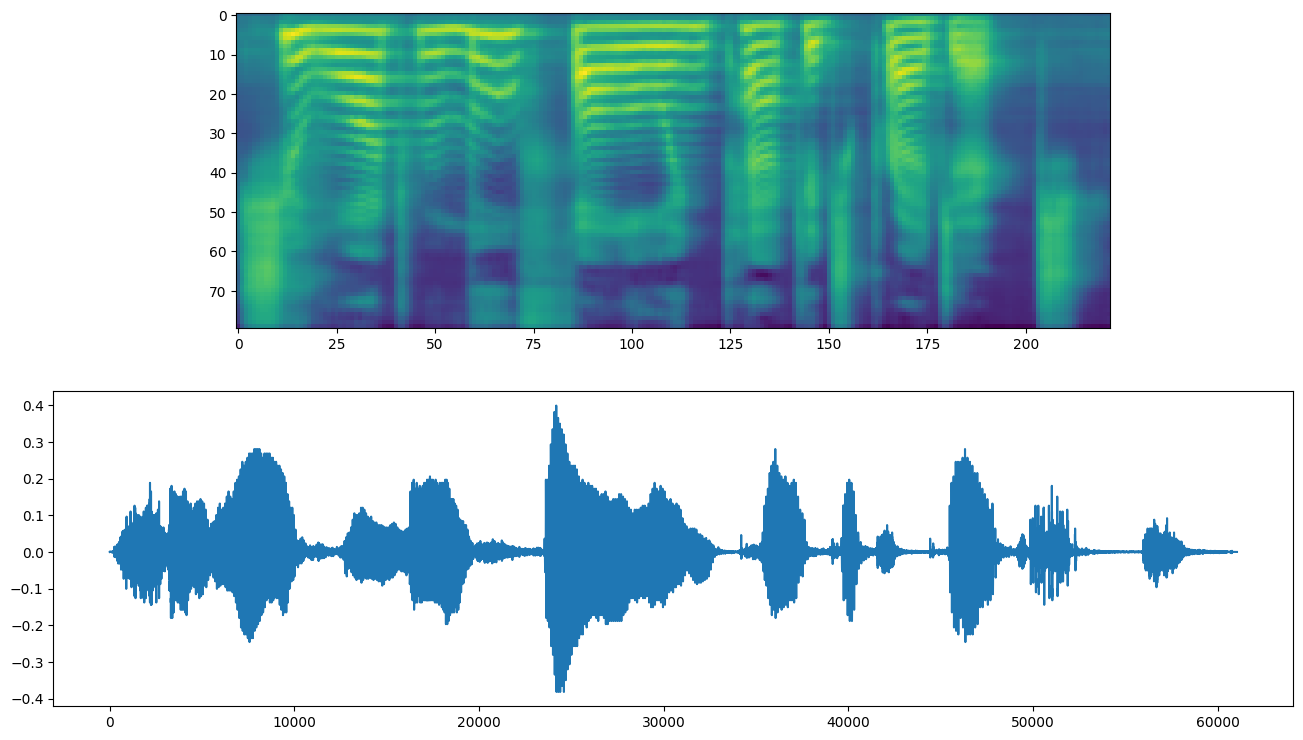

In [ ]:
#Waveform Generation
#WaveRNN

bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

text = predicted_trans

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
    waveforms, lengths = vocoder(spec, spec_lengths)

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9))
ax1.imshow(spec[0].cpu().detach())
ax2.plot(waveforms[0].cpu().detach())

IPython.display.Audio(waveforms[0:1].cpu(), rate=vocoder.sample_rate)

Downloading: "https://download.pytorch.org/torchaudio/models/tacotron2_english_phonemes_1500_epochs_ljspeech.pth" to /root/.cache/torch/hub/checkpoints/tacotron2_english_phonemes_1500_epochs_ljspeech.pth
100%|██████████| 107M/107M [00:01<00:00, 62.2MB/s]


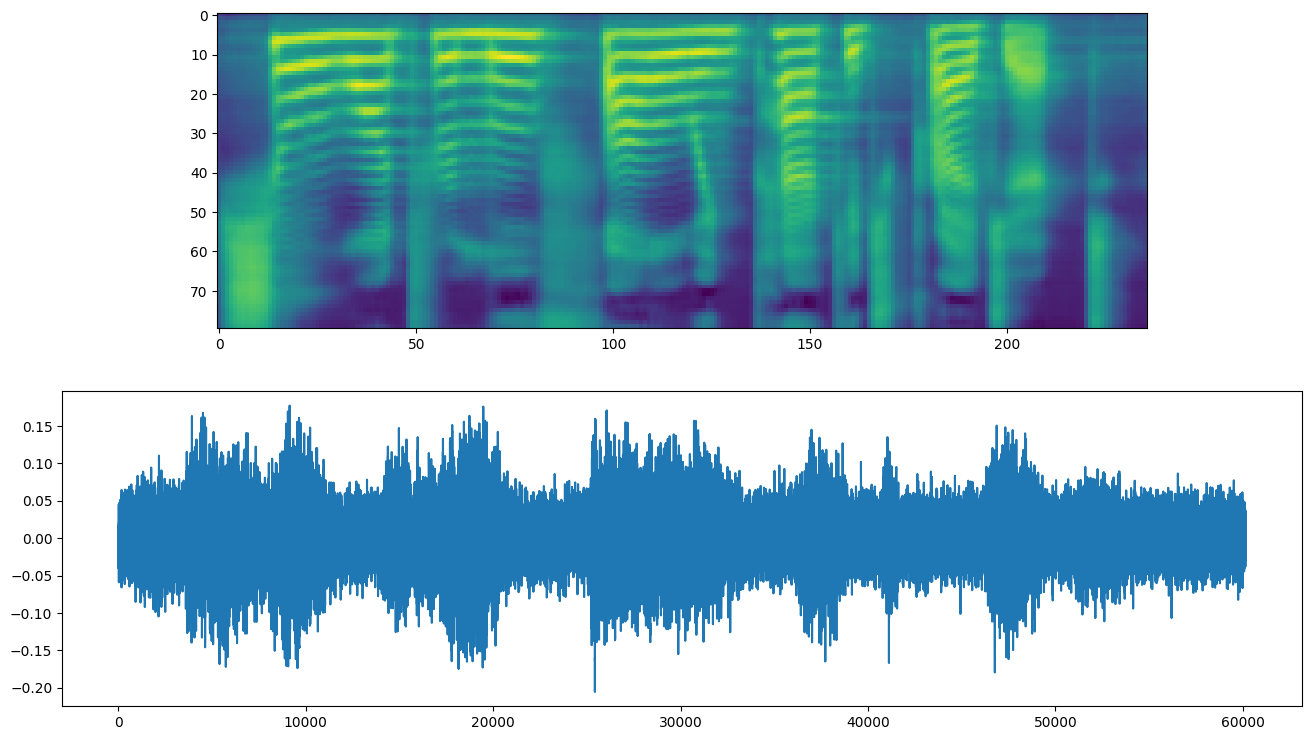

In [ ]:
#Griffin-Lim
bundle = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
waveforms, lengths = vocoder(spec, spec_lengths)

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9))
ax1.imshow(spec[0].cpu().detach())
ax2.plot(waveforms[0].cpu().detach())

IPython.display.Audio(waveforms[0:1].cpu(), rate=vocoder.sample_rate)